In [252]:
# Instalar pandas si no está instalado

%pip install pandas
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [253]:
# Import

import pandas as pd
import numpy as np


In [254]:
# Utils

def show_data_summary(data):
    print(f'Size: {data.size}')
    print(f'Columns: {len(data.columns)}')
    print(f'Rows: {data.shape[0]}')
    print(f'Unique clients: {len(data.client_id.unique())}')


In [255]:
# Load data

data = pd.read_csv('./data.csv', delimiter='|', skipfooter=1, engine='python')

show_data_summary(data)


Size: 18373355
Columns: 77
Rows: 238615
Unique clients: 26560


In [256]:
# Remove summary row

data = data[(data.client_id != '(238615 rows affected)')]

show_data_summary(data)


Size: 18373355
Columns: 77
Rows: 238615
Unique clients: 26560


In [257]:
# Remove duplicates

data = data.drop_duplicates(subset=['Month', 'client_id'])

show_data_summary(data)


Size: 18373355
Columns: 77
Rows: 238615
Unique clients: 26560


In [258]:
# Get clients with 9 months data

nine_mouths = data.groupby('client_id')['Month'].count().reset_index()
clients_with_9_months = data.merge(
    nine_mouths[nine_mouths.Month == 9][['client_id']],
    how='inner',
    on='client_id',
)

show_data_summary(clients_with_9_months)


Size: 18352719
Columns: 77
Rows: 238347
Unique clients: 26483


##### Windows

- Training window: 6 month (from 2018-11-01 to 2019-01-01)
- Lead window: 1 month (2019-02-01)
- Prediction window: last 2 month (2019-03-01 and 2019-04-01)


In [259]:
# Get last training month clients without cobranding

last_training_month = '2019-01-01'
last_training_month_data = clients_with_9_months[clients_with_9_months.Month == last_training_month]

clients_without_cobranding = clients_with_9_months.merge(
    last_training_month_data[last_training_month_data.CreditCard_CoBranding == 'No'][['client_id']],
    how='inner',
    on='client_id',
)

show_data_summary(clients_without_cobranding)


Size: 16386678
Columns: 77
Rows: 212814
Unique clients: 23646


In [260]:
# Get last training month clients without package active

last_training_month_data = clients_without_cobranding[
    clients_without_cobranding.Month == last_training_month]

clients_without_cobranding_without_package = clients_without_cobranding.merge(
    last_training_month_data[last_training_month_data.Package_Active == 'No'][['client_id']],
    how='inner',
    on='client_id',
)

show_data_summary(clients_without_cobranding_without_package)


Size: 16071363
Columns: 77
Rows: 208719
Unique clients: 23191


In [261]:
# Identity features

identity_features_columns = [
    'client_id', 'Month', 'First_product_dt', 'Last_product_dt',
    'CreditCard_Premium', 'CreditCard_CoBranding', 'CreditCard_Active',
    'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
    'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
    'DebitCard_Active', 'Investment_Active',
    'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
    'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
    'Client_Age_grp', 'Mobile', 'Email',  'Region', 'CreditCard_Product'
]
identity_features = clients_without_cobranding_without_package[
    clients_without_cobranding_without_package.Month == last_training_month
][identity_features_columns]

show_data_summary(identity_features)


Size: 602966
Columns: 26
Rows: 23191
Unique clients: 23191


In [262]:
# Remove nulls
# identity_features.columns[identity_features.isnull().any()].tolist() -> [Region, CreditCard_Product]

# Remove nulls of Region
region_from_future = data[data.Month == '2019-03-01'].groupby(['Region', 'client_id']).size().reset_index()
identity_features.drop('Region', axis=1, inplace=True)
identity_features = identity_features.merge(region_from_future[['Region', 'client_id']], on='client_id', how='left')
identity_features['Region'] = identity_features['Region'].fillna('Missing')

# Remove nulls of CreditCard_Product
credit_card_product_from_future = data[data.Month == '2019-03-01'].groupby(['CreditCard_Product', 'client_id']).size().reset_index()
identity_features.drop('CreditCard_Product', axis=1, inplace=True)
identity_features = identity_features.merge(credit_card_product_from_future[['CreditCard_Product', 'client_id']], on='client_id', how='left')
identity_features['CreditCard_Product'] = identity_features['CreditCard_Product'].fillna('Missing')
identity_features['CreditCard_Product'] = np.where(identity_features.CreditCard_Active == 'No', 'No', identity_features.CreditCard_Product)

# Add values to nulls of SavingAccount_Balance_Average
clients_without_cobranding_without_package['SavingAccount_Balance_Average'] = np.where(
    clients_without_cobranding_without_package.SavingAccount_Balance_Average.isnull(),
    (clients_without_cobranding_without_package.SavingAccount_Balance_FirstDate + clients_without_cobranding_without_package.SavingAccount_Balance_LastDate) / 2,
    clients_without_cobranding_without_package.SavingAccount_Balance_Average
)


In [263]:
# Transforms features

# Age group to ordinal
age_group_ordinals = {
    'Menor a 18 años': 1800,
    'Entre 18 y 29 años': 1829,
    'Entre 30 y 39 años': 3039,
    'Entre 40 y 49 años': 4049,
    'Entre 50 y 59 años': 5059,
    'Entre 60 y 64 años': 6064,
    'Entre 65 y 69 años': 6569,
    'Mayor a 70 años': 7000,
}
identity_features['Client_Age_grp_ordinal'] = identity_features['Client_Age_grp'].map(age_group_ordinals)

# Sum Insurances
insurance_fields = [
    'Insurance_Life',
    'Insurance_Home',
    'Insurance_Accidents',
    'Insurance_Mobile',
    'Insurance_ATM',
    'Insurance_Unemployment',
]
identity_features['Active_Insurances'] = identity_features[insurance_fields].apply(lambda row: sum(np.where(row == 'Yes', 1, 0)), axis=1)
identity_features['Active_Insurance'] = np.where(identity_features.Active_Insurances > 0, 'Ÿes', 'No')

# Sum Products
products_fields = [
    'Loan_Active',
    'Mortgage_Active',
    'CreditCard_Active',
    'SavingAccount_Active_ARG',
    'SavingAccount_Active_DOLLAR',
    'DebitCard_Active',
    'Active_Insurance',
]
identity_features['Active_Products'] = identity_features[products_fields].apply(lambda row: sum(np.where(row == 'Yes', 1, 0)), axis=1)

show_data_summary(identity_features)

Size: 695730
Columns: 30
Rows: 23191
Unique clients: 23191


In [264]:
# Sum Operations
operation_fields = [column for column in clients_without_cobranding_without_package.columns if 'Operations' in column]
clients_without_cobranding_without_package['Operations'] = clients_without_cobranding_without_package[operation_fields].sum(axis=1).astype(int)
operation_ratios = clients_without_cobranding_without_package[operation_fields].div(clients_without_cobranding_without_package['Operations'], axis=0)
operation_ratios = operation_ratios.multiply(100).fillna(0).astype(int)

for operation_field in operation_fields:
    clients_without_cobranding_without_package[f'Operations_{operation_field}_vs_total'] = operation_ratios[operation_field]

show_data_summary(clients_without_cobranding_without_package)

Size: 17741115
Columns: 85
Rows: 208719
Unique clients: 23191


In [265]:
# Sum Transactions
transaction_fields = [column for column in clients_without_cobranding_without_package.columns if 'Transactions' in column and 'SavingAccount' in column]
clients_without_cobranding_without_package['Transactions'] = clients_without_cobranding_without_package[transaction_fields].sum(axis=1).astype(int)
transaction_ratios = clients_without_cobranding_without_package[transaction_fields].div(clients_without_cobranding_without_package['Transactions'], axis=0)
transaction_ratios = transaction_ratios.multiply(100).fillna(0).astype(int)

for transaction_field in transaction_fields:
    clients_without_cobranding_without_package[f'Transactions_{transaction_field}_vs_total'] = transaction_ratios[transaction_field]

show_data_summary(clients_without_cobranding_without_package)

Size: 20037024
Columns: 96
Rows: 208719
Unique clients: 23191


In [266]:
# Sum Payments
payment_fields = [column for column in clients_without_cobranding_without_package.columns if 'Payment' in column]
clients_without_cobranding_without_package['Payments'] = clients_without_cobranding_without_package[payment_fields].sum(axis=1).astype(int)
payment_ratios = clients_without_cobranding_without_package[payment_fields].div(clients_without_cobranding_without_package['Payments'], axis=0)
payment_ratios = payment_ratios.multiply(100).fillna(0).astype(int)

for payment_field in payment_fields:
    clients_without_cobranding_without_package[f'Payments_{payment_field}_vs_total'] = payment_ratios[payment_field]

show_data_summary(clients_without_cobranding_without_package)

Size: 23376528
Columns: 112
Rows: 208719
Unique clients: 23191


In [267]:
# Aggregate features

# Months between products
identity_features['First_product_dt'] = pd.to_datetime(identity_features['First_product_dt'])
identity_features['Last_product_dt'] = pd.to_datetime(identity_features['Last_product_dt'])
identity_features['Month'] = pd.to_datetime(identity_features['Month'])
identity_features['Last_first_product_Months'] = ((identity_features['Last_product_dt'] - identity_features['First_product_dt']).dt.days) / 30
identity_features['Month_first_product_Months'] = ((identity_features['Month'] - identity_features['First_product_dt']).dt.days) / 30
identity_features['Month_last_product_Months'] = ((identity_features['Month'] - identity_features['Last_product_dt']).dt.days) / 30

# Card debit vs credit
clients_without_cobranding_without_package['Card_Debit_vs_credit'] = np.where(
    clients_without_cobranding_without_package['SavingAccount_DebitCard_Spend_Amount'] == 0,
    clients_without_cobranding_without_package['CreditCard_Total_Spending'],
    (clients_without_cobranding_without_package['CreditCard_Total_Spending'] / clients_without_cobranding_without_package['SavingAccount_DebitCard_Spend_Amount'])
)

# SavingAccount debit vs credit
clients_without_cobranding_without_package['SavingAccount_Debit_vs_credit'] = np.where(
    clients_without_cobranding_without_package['SavingAccount_Debits_Amounts'] == 0,
    clients_without_cobranding_without_package['SavingAccount_Credits_Amounts'],
    (clients_without_cobranding_without_package['SavingAccount_Credits_Amounts'] / clients_without_cobranding_without_package['SavingAccount_Debits_Amounts'])
)

# Parse and add data for money fields
# - Add value in CER - Coeficiente de Estabilización de Referencia (Argentina only)
# - Add min, max, mean, median, etc stats values
# - Remove outliers (from min to 3-sigma)
CER_VALUES = {
    '2018-08-01': 9.9316,
    '2018-09-01': 10.2663,
    '2018-10-01': 10.6234,
    '2018-11-01': 11.1948,
    '2018-12-01': 11.8454,
    '2019-01-01': 12.3512,
    '2019-02-01': 12.7058,
    '2019-03-01': 13.0390,
    '2019-04-01': 13.5000,
}
def calculate_with_cer(row, field):
    month = row['Month']
    cer_value = CER_VALUES.get(month)
    return row[field] / cer_value

def process_money_field(data, field, min=0, sigmas=3):
    new_data = data.copy()

    # Remove data from min
    new_data[field] = np.where(new_data[field] < min, min, new_data[field])

    # Remove outliers N sigmas
    sigma = sigmas * new_data[new_data[field] >= min][field].std()
    new_data[field] = np.where(new_data[field] > sigma, sigma, new_data[field])

    # Add CER (Coeficiente de Estabilización de Referencia) value
    field_cer = f'{field}_CER'
    new_data[field_cer] = new_data.apply(calculate_with_cer, args=(field,), axis=1)

    # Add stats columns
    aggregations = new_data.groupby(['client_id'])[[field, field_cer]].agg([
        np.sum, np.amax, np.min, np.mean, np.median, np.count_nonzero, np.var
    ]).reset_index()
    aggregations.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in aggregations.columns]
    aggregations.reset_index()
    new_data = new_data.merge(
        aggregations[aggregations.columns],
        how='inner',
        on='client_id',
    )

    return new_data


money_fields = [
    'SavingAccount_Balance_FirstDate',
    'SavingAccount_Balance_LastDate',
    'SavingAccount_Balance_Average',
    'SavingAccount_Salary_Payment_Amount',
    'SavingAccount_Transfer_In_Amount',
    'SavingAccount_ATM_Extraction_Amount',
    'SavingAccount_Service_Payment_Amount',
    'SavingAccount_CreditCard_Payment_Amount',
    'SavingAccount_Transfer_Out_Amount',
    'SavingAccount_DebitCard_Spend_Amount',
    'SavingAccount_Total_Amount',
    'SavingAccount_Credits_Amounts',
    'SavingAccount_Debits_Amounts',
    'CreditCard_Balance_ARG',
    'CreditCard_Total_Limit',
    'CreditCard_Total_Spending',
]
clients_with_aggregations = clients_without_cobranding_without_package.copy()
for money_field in money_fields:
    clients_with_aggregations = process_money_field(clients_with_aggregations, money_field, min=0 if money_field != 'SavingAccount_Balance_Average' else 150)
clients_with_aggregations = clients_with_aggregations.groupby(['client_id']).first().reset_index()

show_data_summary(identity_features)
show_data_summary(clients_without_cobranding_without_package)
show_data_summary(clients_with_aggregations)

/tmp/ipykernel_94450/685482098.py:60: FutureWarning: The provided callable <function sum at 0x7f80b8602340> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  aggregations = new_data.groupby(['client_id'])[[field, field_cer]].agg([
/tmp/ipykernel_94450/685482098.py:60: FutureWarning: The provided callable <function min at 0x7f80b8602b60> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  aggregations = new_data.groupby(['client_id'])[[field, field_cer]].agg([
/tmp/ipykernel_94450/685482098.py:60: FutureWarning: The provided callable <function mean at 0x7f80b8603420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  aggregations = new_data.groupby(['client_id'

Size: 765303
Columns: 33
Rows: 23191
Unique clients: 23191
Size: 23793966
Columns: 114
Rows: 208719
Unique clients: 23191
Size: 8209614
Columns: 354
Rows: 23191
Unique clients: 23191


In [268]:
# Print operations vs columns
[print(col) for col in clients_with_aggregations.columns if 'Operations' in col and 'vs' in col]

# Print transactions vs columns
[print(col) for col in clients_with_aggregations.columns if 'Transactions' in col and 'vs' in col]

# Print payments vs columns
[print(col) for col in clients_with_aggregations.columns if 'Payments' in col and 'vs' in col]

# Print ordinal columns
[print(col) for col in clients_with_aggregations.columns if 'ordinal' in col]

# Print Active_Insurance columns
[print(col) for col in clients_with_aggregations.columns if 'Active_Insurance' in col]

# Print money columns
[print(col) for col in clients_with_aggregations.columns if 'CreditCard_Balance_ARG' in col and 'CER' not in col]
[print(col) for col in clients_with_aggregations.columns if 'CreditCard_Balance_ARG' in col and 'CER' in col]

show_data_summary(clients_with_aggregations)

Operations_Operations_Bank_vs_total
Operations_Operations_Terminal_vs_total
Operations_Operations_HomeBanking_vs_total
Operations_Operations_Mobile_vs_total
Operations_Operations_Ivr_vs_total
Operations_Operations_Telemarketer_vs_total
Operations_Operations_ATM_vs_total
Transactions_SavingAccount_Salary_Payment_Transactions_vs_total
Transactions_SavingAccount_Transfer_In_Transactions_vs_total
Transactions_SavingAccount_ATM_Extraction_Transactions_vs_total
Transactions_SavingAccount_Service_Payment_Transactions_vs_total
Transactions_SavingAccount_CreditCard_Payment_Transactions_vs_total
Transactions_SavingAccount_Transfer_Out_Transactions_vs_total
Transactions_SavingAccount_DebitCard_Spend_Transactions_vs_total
Transactions_SavingAccount_Transactions_Transactions_vs_total
Transactions_SavingAccount_Credits_Transactions_vs_total
Transactions_SavingAccount_Debits_Transactions_vs_total
Payments_SavingAccount_Salary_Payment_Transactions_vs_total
Payments_SavingAccount_Service_Payment_Transa

In [269]:
# Create ABT table

target_1 = data[(data.Month.isin(['2019-04-01', '2019-03-01']) & (data.Target == 1))][['client_id']].drop_duplicates()
target_1['TGT'] = 1

last_training_month_data = clients_without_cobranding_without_package[clients_without_cobranding_without_package.Month == last_training_month]
target = last_training_month_data.merge(target_1, how='left', on='client_id').fillna(0).drop('Target', axis=1)

columns_to_delete_on_target = set()
for identity_column in identity_features.columns:
    if identity_column in target.columns:
        columns_to_delete_on_target.add(identity_column)
columns_to_delete_on_target.remove('client_id')
target = target.drop(columns=columns_to_delete_on_target).reset_index()

ABT = target.merge(identity_features, how='inner', on='client_id')
ABT = ABT.drop(columns=money_fields, axis=1)

columns_to_delete_on_aggregation = set()
for abt_column in ABT.columns:
    if abt_column in clients_with_aggregations.columns:
        columns_to_delete_on_aggregation.add(abt_column)
columns_to_delete_on_aggregation.remove('client_id')
clients_with_aggregations = clients_with_aggregations.drop(columns=columns_to_delete_on_aggregation)

ABT = ABT.merge(clients_with_aggregations, how='inner', on='client_id')

show_data_summary(ABT)

Size: 8418333
Columns: 363
Rows: 23191
Unique clients: 23191


In [270]:
# Remove columns with unique values

x = pd.DataFrame(ABT.describe().T)
delete = x[x['min'] == x['max']].reset_index()
delete.head(200)

columns_to_delete = delete['index'].tolist()
ABT = ABT.drop(columns=columns_to_delete)

show_data_summary(ABT)

Size: 8325569
Columns: 359
Rows: 23191
Unique clients: 23191


In [271]:
# Create correlation matrix

# Convert columns with dtype object to dtype string
ABT = ABT.convert_dtypes()
string_columns = ABT.select_dtypes('string').columns

# Get correlation matrix
corr_matrix = ABT.drop(['client_id', 'TGT'] + list(string_columns), axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).fillna(0)

# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Create csv to check
upper.to_csv('./correlation.csv', sep='|',  header=True , encoding='utf-8', index=False)

# Drop features 
ABT.drop(to_drop, axis=1, inplace = True)

show_data_summary(ABT)

Size: 2620583
Columns: 113
Rows: 23191
Unique clients: 23191


In [272]:
# Install sklearn (scikit-learn)

%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [273]:
# ABT standardization

from sklearn.preprocessing import StandardScaler

# Number standardization
numeric_columns = set(ABT.select_dtypes(include=['int', 'float']).columns)
numeric_columns.remove('client_id')
numeric_columns.remove('TGT')
scaler = StandardScaler()
ABT[list(numeric_columns)] = scaler.fit_transform(ABT[list(numeric_columns)])

# String standardization
string_columns = ABT.select_dtypes(include=['string']).columns
ABT = pd.get_dummies(ABT, columns=string_columns)

# Datetime standardization
datetime_columns = ABT.select_dtypes(include='datetime').columns
for datetime_column in datetime_columns:
    ABT[datetime_column] = ABT[datetime_column].astype(int) // 10**9

ABT.dtypes.value_counts()

float64    85
bool       57
Int64       2
int64       2
Name: count, dtype: int64

In [274]:
# Install xgboost

%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [275]:
# Get best hyperparameter combination for xgboost model

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Remove not feature columns
X = ABT.drop(columns=['client_id', 'index', 'Target', 'TGT'])
y = ABT['TGT']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to the DMatrix structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the list of hyperparameters to try
param_grid = {
    'max_depth': np.arange(4, 6, 1),
    'learning_rate': np.arange(0.02, 0.3, 0.02),
    'num_parallel_tree': np.arange(1, 5, 1),
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss', 'auc'],
    'seed': [42],
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1, # Use all processors
    verbose=3, # Show details per iteration
)

# Perform hyperparameter tuning and get the best combination
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best hyperparameter combination: ', best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Set the hyperparameter for xgb.train
xgb_params = {
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'num_parallel_tree': best_params['num_parallel_tree'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42,
}

print(xgb_params)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV 5/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=1, objective=binary:logistic, seed=42;, score=0.851 total time=   2.1s
[CV 3/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=1, objective=binary:logistic, seed=42;, score=0.842 total time=   2.3s
[CV 2/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=1, objective=binary:logistic, seed=42;, score=0.844 total time=   2.4s
[CV 1/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=1, objective=binary:logistic, seed=42;, score=0.850 total time=   2.5s
[CV 4/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=1, objective=binary:logistic, seed=42;, score=0.842 total time=   2.7s
[CV 2/5] END eval_metric=logloss, learning_rate=0.02, max_depth=4, num_parallel_tree=2, objective=binary:logistic, seed=42;, score=0.844 total time=   7.6s


In [276]:
# Get best num_boost_round for xgboost model

# Options of num_boost_round to try
round_values = [25, 50, 75, 100, 125, 150]
best_roc_auc = 0
best_num_boost_round = 0

# Get best num_boost_round by roc_auc
for round_val in round_values:
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=round_val)
    y_pred = xgb_model.predict(dtest)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f'num_boost_round={round_val} - ROC AUC: {roc_auc}')

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_num_boost_round = round_val

print(f'best_roc_auc: {best_roc_auc}')
print(f'best_num_boost_round: {best_num_boost_round}')

num_boost_round=25 - ROC AUC: 0.8499079664837165
num_boost_round=50 - ROC AUC: 0.8516399613101819
num_boost_round=75 - ROC AUC: 0.85305497662304
num_boost_round=100 - ROC AUC: 0.8540440018496056
num_boost_round=125 - ROC AUC: 0.8540969434597007
num_boost_round=150 - ROC AUC: 0.8540302638368593
best_roc_auc: 0.8540969434597007
best_num_boost_round: 125


In [277]:
# Run best xgb model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=best_num_boost_round)
y_pred = xgb_model.predict(dtest)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.8540969434597007


In [278]:
# Get feature importances

importance_dict = xgb_model.get_score(importance_type='weight')
feature_importances = pd.DataFrame(list(importance_dict.items()), columns=['feature', 'importance'])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

feature_importances

,feature,importance
47,Last_product_dt,130.0
74,CreditCard_Balance_ARG_var,116.0
48,Client_Age_grp_ordinal,108.0
62,CreditCard_Total_Spending,103.0
46,First_product_dt,97.0
...,...,...
90,Client_Age_grp_Entre 60 y 64 años,1.0
88,Client_Age_grp_Entre 40 y 49 años,1.0
94,Region_AMBA Resto,1.0
80,Mortgage_Active_No,1.0


In [279]:
# Get top n best feature importances

top_n = 25
selected_features = feature_importances.head(top_n)['feature'].tolist()

feature_importances.head(top_n)

,feature,importance
47,Last_product_dt,130.0
74,CreditCard_Balance_ARG_var,116.0
48,Client_Age_grp_ordinal,108.0
62,CreditCard_Total_Spending,103.0
46,First_product_dt,97.0
72,SavingAccount_Total_Amount_min,97.0
52,SavingAccount_Balance_LastDate,93.0
76,CreditCard_Total_Spending_var,87.0
26,Operations,84.0
50,Last_first_product_Months,84.0


In [280]:
# Recreate model with only best n features

X = ABT.drop(columns=['client_id', 'index', 'Target', 'TGT'])[selected_features]
y = ABT['TGT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=best_num_boost_round)
y_pred = xgb_model.predict(dtest)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.8439184163086966


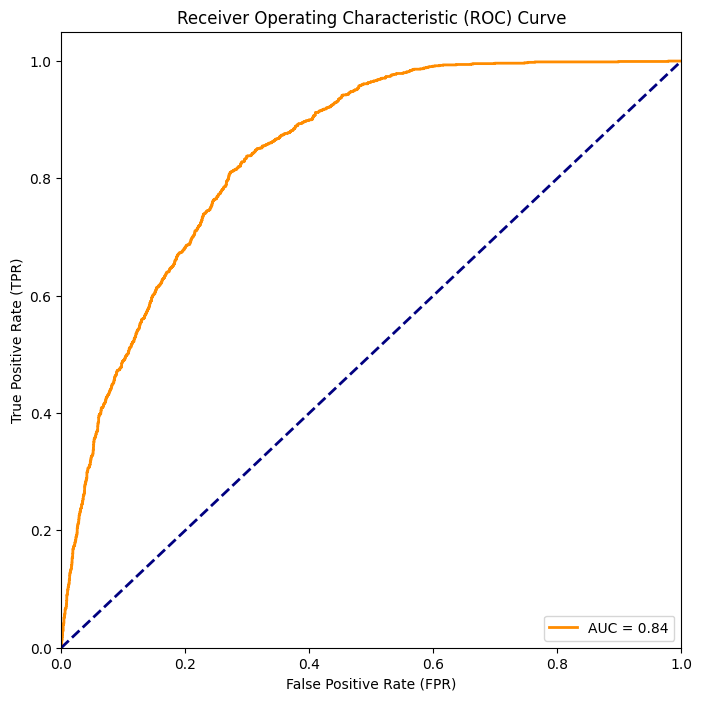

In [281]:
# Show ROC curve with TRP vs FPR graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get ROC curve
probabilities = xgb_model.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Graph ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [282]:
# Get deciles with data for training

probabilities_train = xgb_model.predict(dtrain)
probabilities = xgb_model.predict(dtest)

a_train = pd.DataFrame({'TGT': y_train, 'idx': X_train.index})
a_train.reset_index(inplace=True)
b_train = pd.DataFrame({'Prob1': probabilities_train}, columns=['Prob1'])

result_train = pd.concat([a_train, b_train], axis=1)

result_train['porc'] = result_train['Prob1'].rank(pct=True) * 100
result_train['decil'] = pd.cut(result_train['porc'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=list(range(10, 0, -1)))

print(result_train.decil.value_counts())
print(result_train[result_train.TGT == 1].decil.value_counts())


decil
6     1856
1     1856
10    1855
9     1855
8     1855
7     1855
5     1855
4     1855
3     1855
2     1855
Name: count, dtype: int64
decil
1     1616
2     1232
3      910
4      717
5      500
6      288
7      132
8       49
9        7
10       3
Name: count, dtype: int64


In [283]:
# Get deciles with data for testing

a_test = pd.DataFrame({'TGT': y_test, 'idx': X_test.index})
a_test.reset_index(inplace=True)

b_test = pd.DataFrame({'Prob1': probabilities}, columns=['Prob1'])

result_test = pd.concat([a_test, b_test], axis=1)

result_test['porc'] = result_test['Prob1'].rank(pct=True) * 100
result_test['decil'] = pd.cut(result_test['porc'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=list(range(10, 0, -1)))

print(result_test.decil.value_counts())
print(result_test[result_test.TGT == 1].decil.value_counts())

decil
9     464
8     464
7     464
6     464
5     464
4     464
3     464
2     464
1     464
10    463
Name: count, dtype: int64
decil
1     348
2     290
3     220
4     189
5     140
6     103
7      61
8      13
9       3
10      2
Name: count, dtype: int64
